<a href="https://colab.research.google.com/gist/onuryartasi/7b861ff3cff77bcf68846db3bec0b2a6/chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 435      Final Project-ChatBot
**_Jing Zhang, Chengsui Feng_**

In [1]:
import numpy as np
import re 
import time
import tensorflow as tf

## 1. Data Processing

Before building the Model, we preprocess the data first. Our datasets are from [Cornell Movie-Quotes Corpus](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html), including  'movie_lines.txt' and 'movie_conversations.txt'. As the datasets use index to represent the lines, we build the maps of line/coversation and id.

In addition, in order to obtain better material of training the Chatbot, we divide the conversations material into the answers and questions. Also, to clean the raw data, we build a function using some regular expression rules.

After that, we transform the answers into integers, and add special tokens to the appropriate spaces. In the end, we sort these answers and questions according to the length of the questions.

In [ ]:
############## PART 1 - DATA PREPROCESSING ###############

# Importing the dataset
lines = open('/content/gdrive/My Drive/Colab Notebooks/movie_lines.txt', encoding = 'utf-8', errors='ignore').read().split('\n')
conversations = open('/content/gdrive/My Drive/Colab Notebooks/movie_conversations.txt', encoding = 'utf-8', errors='ignore').read().split('\n')

# Creating a dictionary that maps each Line and its id
id2line = {}

for line in lines:
    _line = line.split(' +++$+++ ')
    if len(_line) == 5:
        id2line[_line[0]] = _line[4]
        

# Creating a list of all the conversations
conversations_ids = []
for conversation in conversations[:-1]:
    _conversation = conversation.split(' +++$+++ ')[-1][1:-1].replace("'", "").replace(" ", "")
    conversations_ids.append(_conversation.split(','))

# Getting separately the questions and the answers
questions = []
answers = []
for conversation in conversations_ids:
    for i in range(len(conversation) - 1):
        questions.append(id2line[conversation[i]])
        answers.append(id2line[conversation[i+1]])
        
# Doing the first cleaning of the texts
def clean_text(text):
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"n't", "not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"[-()\"#/@;:<>{}+=~|.?,]", "", text)
        
    return text

# Cleaning the question
clean_questions = []
for question in questions:    
    clean_questions.append(clean_text(question))

# Cleaning the answers
clean_answers = []
for answer in answers:    
    clean_answers.append(clean_text(answer))

# Creating a dictionary that maps each word to its number of occurences
word2count={}
for question in clean_questions:
    for word in question.split():
        if word not in word2count:
            word2count[word] = 1
        else:
            word2count[word] += 1
            
for answer in clean_answers:
    for word in answer.split():
        if word not in word2count:
            word2count[word] = 1
        else:
            word2count[word] += 1

# Creating two dictionary that map the questions words and the answers words to a unique integer
threshold = 15
questionswords2int = {}
word_number = 0
for word, count in word2count.items():
    if count >= threshold:
        questionswords2int[word] = word_number
        word_number += 1
        
answerswords2int = {}
word_number = 0
for word, count in word2count.items():
    if count >= threshold:
        answerswords2int[word] = word_number
        word_number += 1
        
# Adding the last tokens to these two dictionaries
tokens = ['<PAD>', '<EOS>', '<OUT>', '<SOS>']
for token in tokens:
    questionswords2int[token] = len(questionswords2int) + 1
for token in tokens:
    answerswords2int[token] = len(answerswords2int) + 1
    
# Creating the inverse dictionary of the answerwsword2int dictionary
answersints2word = {w_i: w for w, w_i in answerswords2int.items()}

# Adding the End of String token to the end of every answer
# We are doing this because End of String token is needed at the end of the decoding lays of the seq2seq model
for i in range(len(clean_answers)):
    clean_answers[i] += ' <EOS>'
        
# Translating all the questions and the answers into integers
# And replacing all the words that were filtered out by <OUT>
# We want to sort all the questions and all the answers ny their length to optimize the training performance
questions_into_int = []
for question in clean_questions:
    ints = []
    for word in question.split():
        if word not in questionswords2int:
            ints.append(questionswords2int['<OUT>'])
        else:
            ints.append(questionswords2int[word])
    questions_into_int.append(ints)
    
answers_into_int = []
for answer in clean_answers:
    ints = []
    for word in answer.split():
        if word not in answerswords2int:
            ints.append(answerswords2int['<OUT>'])
        else:
            ints.append(answerswords2int[word])
    answers_into_int.append(ints)
    
# Sorting questions and answers by the length of questions
sorted_clean_questions = []
sorted_clean_answers = []

for length in range(1, 25 + 1):
    for i in enumerate(questions_into_int):
        if len(i[1]) == length:
            sorted_clean_questions.append(questions_into_int[i[0]])
            sorted_clean_answers.append(answers_into_int[i[0]])
        

## 2.Building The Network

In this part, we use tensorflow to build our encoder-Rnn and the decoder-Rnn, First of all, We should know the whole architecture of our sequence to sequence module.
### 1.Encoder and Decoder

The encoder layer consists of input layer, embedding layer, LSTM layer and the decoder layer is made up of the same layer as the encoder but with a Dense layer.
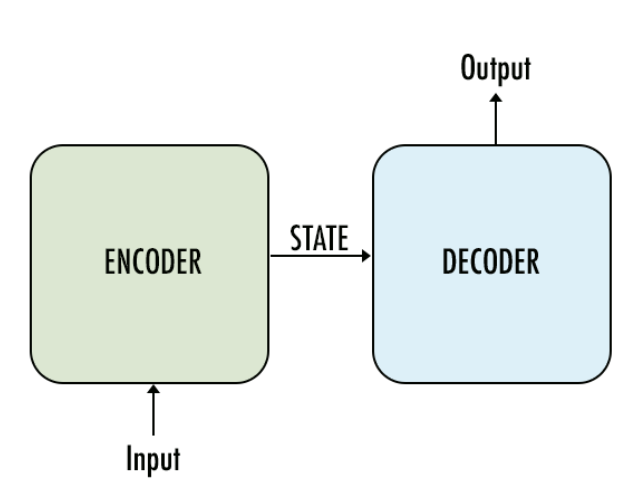
### 2. LSTM

Long Short Term Memory networks – usually just called "LSTMs" – are a special kind of RNN, capable of learning long-term dependencies.
 LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer. LSTMs also have this chain like structure, but the repeating module has a different structure. Instead of having a single neural network layer, there are four, interacting in a very special way.



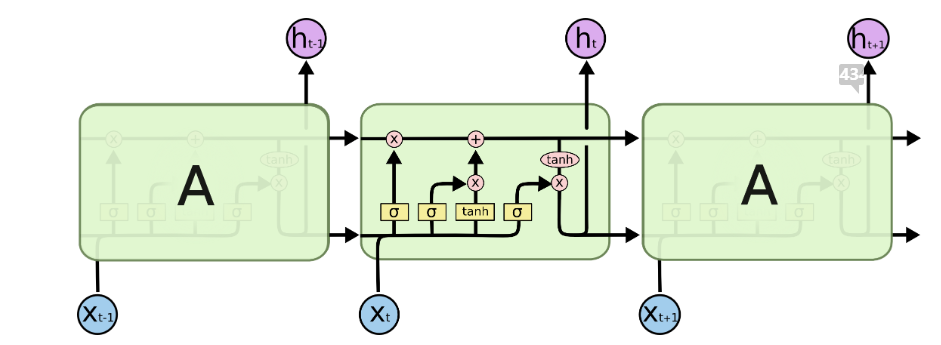

In [0]:
############### PART 2 - BUILDING THE SEQ2SEQ MODEL #########################
            

# Creating placeholders for the inputs and the targets
            
# In tensorflow, all variables are used in tensors, we need to go from the number of ndarrays to tensors
# All the variables used in tensors must be defined as tensorflow placeholders, a more advanced data structure that can contain tensors and other features.

def model_inputs():
    inputs = tf.placeholder(tf.int32, [None, None], name = 'input')
    targets = tf.placeholder(tf.int32, [None, None], name = 'target')
    lr = tf.placeholder(tf.float32, name = 'learning_rate')
    keep_prob = tf.placeholder(tf.float32, name = 'keep_prob') #dropout rate
    return inputs, targets, lr, keep_prob

# Preprocessing the targets : the Answers are the Targets
def preprocess_targets(targets, word2int, batch_size):
    left_side = tf.fill([batch_size, 1], word2int['<SOS>'])
    right_side = tf.strided_slice(targets, [0,0], [batch_size, -1], [1,1])
    preprocessed_targets = tf.concat([left_side, right_side], 1)
    return preprocessed_targets


# Creating the Encoder RNN Layer
def encoder_rnn(rnn_inputs, rnn_size, num_layers, keep_prob, sequence_length):
    lstm = tf.contrib.rnn.BasicLSTMCell(rnn_size)
    lstm_dropout = tf.contrib.rnn.DropoutWrapper(lstm, input_keep_prob = keep_prob)
    encoder_cell = tf.contrib.rnn.MultiRNNCell([lstm_dropout] * num_layers)
    
    # first: encoder_output
    _, encoder_state = tf.nn.bidirectional_dynamic_rnn(cell_fw = encoder_cell,
                                                       cell_bw = encoder_cell,
                                                       sequence_length = sequence_length,
                                                       inputs = rnn_inputs,
                                                       dtype = tf.float32)
    return encoder_state
    

# Decoding the training set
def decode_training_set(encoder_state, decoder_cell, decoder_embedded_input, sequence_length, decoding_scope, output_function, keep_prob, batch_size):
    attention_states = tf.zeros([batch_size, 1, decoder_cell.output_size])
    
    # attention_keys: the key to be compared with the target states
    # attention_value : construct the context vectors. Context is returned by the encoder and be used by the decoder as the first parameter
    # attention_score_function: compute the similarity of the keys and the target states
    # attention_construct_function: build the attention state
    attention_keys, attention_values, attention_score_function, attention_construct_function = tf.contrib.seq2seq.prepare_attention(attention_states, attention_option = 'bahdanau', num_units = decoder_cell.output_size)
    
    training_decoder_function = tf.contrib.seq2seq.attention_decoder_fn_train(encoder_state[0], 
                                                                              attention_keys,
                                                                              attention_values,
                                                                              attention_score_function,
                                                                              attention_construct_function,
                                                                              name = "attn_dec_train")
    
    # second and third output: decoder_final_state, decoder_final_context_state
    decoder_output, _, _ = tf.contrib.seq2seq.dynamic_rnn_decoder(decoder_cell, 
                                                                  training_decoder_function,
                                                                  decoder_embedded_input,
                                                                  sequence_length,
                                                                  scope = decoding_scope)
    
    decoder_output_dropout = tf.nn.dropout(decoder_output, keep_prob)
    return output_function(decoder_output_dropout)


# Decoding the test/validation set
def decode_test_set(encoder_state, decoder_cell, decoder_embedded_matrix, sos_id, eos_id, maximum_length, num_words, decoding_scope, output_function, keep_prob, batch_size):
    attention_states = tf.zeros([batch_size, 1, decoder_cell.output_size])

    attention_keys, attention_values, attention_score_function, attention_construct_function = tf.contrib.seq2seq.prepare_attention(attention_states, attention_option = 'bahdanau', num_units = decoder_cell.output_size)
    
    test_decoder_function = tf.contrib.seq2seq.attention_decoder_fn_inference(output_function,
                                                                              encoder_state[0], 
                                                                              attention_keys,
                                                                              attention_values,
                                                                              attention_score_function,
                                                                              attention_construct_function,
                                                                              decoder_embedded_matrix,
                                                                              sos_id,
                                                                              eos_id,
                                                                              maximum_length,
                                                                              num_words,
                                                                              name = "attn_dec_inf")
    
    test_predictions, _, _ = tf.contrib.seq2seq.dynamic_rnn_decoder(decoder_cell, 
                                                                    test_decoder_function,
                                                                    scope = decoding_scope)
    
    return test_predictions
    
# Creating the Decoder RNN
def decoder_rnn(decoder_embedded_input, decoder_embeddigs_matrix, encoder_state, num_words, sequence_length, rnn_size, num_layers, word2int, keep_prob, batch_size):
    with tf.variable_scope('decoding') as decoding_scope:
        lstm = tf.contrib.rnn.BasicLSTMCell(rnn_size)
        lstm_dropout = tf.contrib.rnn.DropoutWrapper(lstm, input_keep_prob = keep_prob)
        decoder_cell = tf.contrib.rnn.MultiRNNCell([lstm_dropout] * num_layers)
        weights = tf.truncated_normal_initializer(stddev = 0.1)
        biases = tf.zeros_initializer()
        
        # fully connected layer
        output_function = lambda x: tf.contrib.layers.fully_connected(x, 
                                                                      num_words,
                                                                      None,
                                                                      scope = decoding_scope,
                                                                      weights_initializer = weights,
                                                                      biases_initializer = biases)
        
        training_predictions = decode_training_set(encoder_state,
                                                   decoder_cell,
                                                   decoder_embedded_input,
                                                   sequence_length,
                                                   decoding_scope,
                                                   output_function,
                                                   keep_prob,
                                                   batch_size)
        
        decoding_scope.reuse_variables()
        test_predictions = decode_test_set(encoder_state,
                                           decoder_cell,
                                           decoder_embeddigs_matrix,
                                           word2int['<SOS>'],
                                           word2int['<EOS>'],
                                           sequence_length - 1,
                                           num_words,
                                           decoding_scope,
                                           output_function,
                                           keep_prob,
                                           batch_size)
        
        return training_predictions, test_predictions
        
# Building the seq2seq model
def seq2seq_model(inputs, targets, keep_prob, batch_size, sequence_length, answers_num_words, questions_num_words, encoder_embedding_size, decoder_embedding_size, rnn_size, num_layers, questionswords2int):
    encoder_embedded_input = tf.contrib.layers.embed_sequence(inputs, 
                                                              answers_num_words + 1,
                                                              encoder_embedding_size,
                                                              initializer = tf.random_uniform_initializer(0 ,1))
    encoder_state = encoder_rnn(encoder_embedded_input, rnn_size, num_layers, keep_prob, sequence_length)
    preprocessed_targets = preprocess_targets(targets,
                                              questionswords2int,
                                              batch_size)
    decoder_embeddings_matrix = tf.Variable(tf.random_uniform([questions_num_words + 1, decoder_embedding_size], 0, 1))
    decoder_embedded_input = tf.nn.embedding_lookup(decoder_embeddings_matrix, preprocessed_targets)
    
    training_predictions, test_predictions = decoder_rnn(decoder_embedded_input,
                                                         decoder_embeddings_matrix,
                                                         encoder_state,
                                                         questions_num_words,
                                                         sequence_length,
                                                         rnn_size,
                                                         num_layers,
                                                         questionswords2int,
                                                         keep_prob,
                                                         batch_size)
    
    return training_predictions, test_predictions

## 3.Training the SEQ2SEQ Model

After building the architecture beneath, we set up the neural net and train it. After we input the batches of data, the network forward-propagates it inside the encoder and gets encoder states.Then it forward-propagates encoder states with the targets inside the decoder RNN to get the final output (scores) and answers predicted by the chatbot. Then it backpropagtes the loss generated by the outputs and the target back into the NN, and at last updates the weights.


In [0]:
################ PART 3 - TRAINING THE SEQ2SEQ MODEL #########################
    
### Setting the Hyperparameters ###
    
# One epoch is basically one whole iteration of training
    
# Getting the batches of input into the neural-networks then forward-propagating them inside the encoders getting encoder states(?)
# Forward-propagating encoder states with the targets inside the decoder RNN to get the final output (scores) and answers predicted by the chatbot.
# Then backpropagting the loss generated by the outputs and the target back into the NN, and updating the weights.
    
epochs = 100  #50
batch_size = 32  #128
rnn_size = 1024
num_layers = 3

# the number of columns in the embedding matrix that is the number you want to have for the embedding values
# In this matrix each line corresponds to each token in the while corpus of the questions
encoding_embedding_size = 1024
decoding_embedding_size = 1024

learning_rate = 0.001

# the percentage the learning rate is reduced over the iterations of the training
learning_rate_decay = 0.9
min_learning_rate = 0.0001

# (1 - dropout_rate)
keep_probability = 0.5


#Defining a session ###
tf.reset_default_graph()
session = tf.InteractiveSession()

# Loading the model input
inputs, targets, lr, keep_prob = model_inputs()

# Setting the sequence length
sequence_length = tf.placeholder_with_default(25, None, name = 'sequence_length')

# Getting the shape of the input tensor
input_shape = tf.shape(inputs)

# Getting the training and test perdictions
training_predictions, test_predictions = seq2seq_model(tf.reverse(inputs, [-1]), 
                                                       targets, 
                                                       keep_prob,
                                                       batch_size,
                                                       sequence_length,
                                                       len(answerswords2int),
                                                       len(questionswords2int),
                                                       encoding_embedding_size,
                                                       decoding_embedding_size,
                                                       rnn_size,
                                                       num_layers,
                                                       questionswords2int)

# Setting up the Loss Error, the Optimizer and Gradient Clipping
with tf.name_scope("optimization"):
    loss_error = tf.contrib.seq2seq.sequence_loss(training_predictions, 
                                                targets,
                                                tf.ones([input_shape[0], sequence_length]))
    optimizer = tf.train.AdamOptimizer(learning_rate)
    gradients = optimizer.compute_gradients(loss_error)
    clipped_gradients = [(tf.clip_by_value(grad_tensor, -5., 5.), grad_variable) for grad_tensor, grad_variable in gradients if grad_tensor is not None]
    optimizer_gradient_clipping = optimizer.apply_gradients(clipped_gradients)

In [0]:
# Padding the sequences with the <PAD> token
# Question: ['Who', 'are', 'you', <PAD>, <PAD>, <PAD>, <PAD>]
# Answer:   [<SOS>, 'I', 'am', 'a', 'bot', '.', <EOS>, <PAD>]

# We want the length of the question sequence is the same as the length of the answer sequence.

def apply_padding(batch_of_sequences, word2int):
    max_sequence_length = max([len(sequence) for sequence in batch_of_sequences])
    return [sequence + [word2int['<PAD>']] * (max_sequence_length - len(sequence)) for sequence in batch_of_sequences]


In [0]:
# Splitting the data into batches of questions and answers
def split_into_batches(questions, answers, batch_size):
    for batch_index in range(0, len(questions) // batch_size):
        start_index = batch_index * batch_size
        questions_in_batch = questions[start_index : start_index + batch_size]
        answers_in_batch = answers[start_index : start_index + batch_size]
        padded_questions_in_batch = np.array(apply_padding(questions_in_batch, questionswords2int))
        padded_answers_in_batch = np.array(apply_padding(answers_in_batch, answerswords2int))
        yield padded_questions_in_batch, padded_answers_in_batch

In [0]:
# Splitting the questions and answers into training and validation sets
training_validation_split = int(len(sorted_clean_questions) * 0.15)
training_questions = sorted_clean_questions[training_validation_split:]
training_answers = sorted_clean_answers[training_validation_split:]
validation_questions = sorted_clean_questions[:training_validation_split]
validation_answers = sorted_clean_answers[:training_validation_split]

As the training procedure takes a long period of time, we save checkpoint files every time we reach a batter validation result, which is, a lower validation loss error. When the error became larger and larger, we knew that the model is getting overfit, and it stopped saving checkpoints. At this time, we would know that we can stop the training and check the results.

In [0]:
# Training

batch_index_check_training_loss = 100
batch_index_check_validation_loss = ((len(training_questions)) // batch_size // 2) - 1
total_training_loss_error = 0
list_validation_loss_error = []
early_stopping_check = 0
early_stopping_stop = 100
checkpoint = "/content/gdrive/My Drive/Colab Notebooks/chatbot_weights.ckpt"

epoch_start_num = 10

batch_index_check_training_loss = 100
batch_index_check_validation_loss = ((len(training_questions)) // batch_size // 2) - 1
total_training_loss_error = 0
list_validation_loss_error = []
early_stopping_check = 0
early_stopping_stop = 100
#checkpoint = "./chatbot_weights.ckpt"
#session.run(tf.global_variables_initializer())
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())
saver = tf.train.Saver()
#saver = tf.train.import_meta_graph(checkpoint)
saver.restore(session, checkpoint)

for epoch in range(epoch_start_num, epochs + 1):
    for batch_index, (padded_questions_in_batch, padded_answers_in_batch) in enumerate(split_into_batches(training_questions, training_answers, batch_size)):
        starting_time = time.time()
        _, batch_training_loss_error = session.run([optimizer_gradient_clipping, loss_error], {inputs: padded_questions_in_batch,
                                                      targets: padded_answers_in_batch, 
                                                      lr: learning_rate,
                                                      sequence_length: padded_answers_in_batch.shape[1],
                                                      keep_prob: keep_probability})
        total_training_loss_error += batch_training_loss_error
        ending_time = time.time()
        batch_time = ending_time - starting_time
        if batch_index % batch_index_check_training_loss == 0:
            print('Epoch: {:>3}/{}, Batch: {:>4}/{}, Training Loss Error: {:>6.3f}, Training Time on 100 Batches: {:d} seconds'.format(epoch,
                                                                                                                                  epochs,
                                                                                                                                  batch_index,
                                                                                                                                  len(training_questions)//batch_size,
                                                                                                                                  total_training_loss_error / batch_index_check_validation_loss,
                                                                                                                                  int(batch_time * batch_index_check_training_loss)))
            total_training_loss_error = 0
        if batch_index % batch_index_check_validation_loss == 0 and batch_index > 0:
            total_validation_loss_error = 0
            starting_time = time.time()
            for batch_index_validation, (padded_questions_in_batch, padded_answers_in_batch) in enumerate(split_into_batches(validation_questions, validation_answers, batch_size)):
                starting_time = time.time()
                batch_validation_loss_error = session.run(loss_error, {inputs: padded_questions_in_batch,
                                                                       targets: padded_answers_in_batch,
                                                                       lr: learning_rate,
                                                                       sequence_length: padded_answers_in_batch.shape[1],
                                                                       keep_prob: 1})
                total_validation_loss_error += batch_validation_loss_error
            ending_time = time.time()
            batch_time = ending_time - starting_time
            average_validation_loss_error = total_validation_loss_error / (len(validation_questions) / batch_size)
            print('Validation Loss Error: {:>6.3f}, Batch Validation Time : {:d} seconds'.format(average_validation_loss_error, int(batch_time)))
            learning_rate += learning_rate_decay
            if learning_rate < min_learning_rate:
                learning_rate = min_learning_rate
            list_validation_loss_error.append(average_validation_loss_error)
            if average_validation_loss_error <= min(list_validation_loss_error):
                print("I speak better now!!")
                early_stopping_check = 0
                saver = tf.train.Saver()
                saver.save(session, checkpoint)
            else:
                print("Sorry I do not speak better, I need to practice more.")
                early_stopping_check += 1
                if early_stopping_check == early_stopping_stop:
                    break
    if early_stopping_check == early_stopping_stop:
        print("My apologies, I cannot speak better anymore. This is the best I can do.")
        break
print("GameOver")

Epoch:  10/100, Batch:    0/5417, Training Loss Error:  0.001, Training Time on 100 Batches: 6561 seconds
Epoch:  10/100, Batch:  100/5417, Training Loss Error:  0.044, Training Time on 100 Batches: 30 seconds
Epoch:  10/100, Batch:  200/5417, Training Loss Error:  0.041, Training Time on 100 Batches: 31 seconds
Epoch:  10/100, Batch:  300/5417, Training Loss Error:  0.041, Training Time on 100 Batches: 88 seconds
Epoch:  10/100, Batch:  400/5417, Training Loss Error:  0.041, Training Time on 100 Batches: 39 seconds
Epoch:  10/100, Batch:  500/5417, Training Loss Error:  0.040, Training Time on 100 Batches: 47 seconds
Epoch:  10/100, Batch:  600/5417, Training Loss Error:  0.042, Training Time on 100 Batches: 54 seconds
Epoch:  10/100, Batch:  700/5417, Training Loss Error:  0.043, Training Time on 100 Batches: 23 seconds
Epoch:  10/100, Batch:  800/5417, Training Loss Error:  0.041, Training Time on 100 Batches: 34 seconds
Epoch:  10/100, Batch:  900/5417, Training Loss Error:  0.042,

## 4. Testing the SEQ2SEQ Model

In [0]:
# Converting the  questions from strings to lists of encoding integers
def convert_string2int(question, word2int):
    question = clean_text(question)
    return [word2int.get(word, word2int['<OUT>']) for word in question.split()]

In [19]:
checkpoint = "/content/gdrive/My Drive/Colab Notebooks/chatbot_weights.ckpt"
#session.run(tf.global_variables_initializer())
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())
saver = tf.train.Saver()
#saver = tf.train.import_meta_graph(checkpoint)
saver.restore(session, checkpoint)

while(True):
    question = input("You: ")
    if question == 'Goodbye':
        break
    question = convert_string2int(question, questionswords2int)
    question = question + [questionswords2int['<PAD>']] * (25 - len(question))
    fake_batch = np.zeros((batch_size, 25))
    fake_batch[0] = question
    predicted_answer = session.run(test_predictions, {inputs: fake_batch, keep_prob: 0.5})[0]
    answer = ''
    for i in np.argmax(predicted_answer, 1):
        if answersints2word[i] == 'i':
            token = 'I'
        elif answersints2word[i] == '<EOS>':
            token = '.'
        elif answersints2word[i] == '<OUT>':
            token = 'out'
        else:
            token = ' ' + answersints2word[i]
        answer += token
        if token == '.':
            break
    print('ChatBot: '+ answer)
        

You: hello, babe
ChatBot: I am not going to get any more of this shitI am going to get it.
You: don't worry
ChatBot: I am sorryI didnot mean to.
You: it's okay
ChatBot: I am not going to beout.
You: I am sorry
ChatBot: I am not going to get you out of this.
You: love you
ChatBot: I am not going to be aout.
You: calm down
ChatBot: I am not going to get you out of here.
You: I'm ok
ChatBot: I am not going to get you out of this.
You: love you, too
ChatBot: I am not going to get you out of here.
You: Goodbye


## 6. Conclusion

From the result, we can see the chatbot can give us answers that have correct grammer, which means that though our model is simple, it has indeed learned some rules of syntax as features. Sometimes it gives us confusing answers which do not make sense to the corresponding questions, this is because it is trained from the movie scripts to some extent, and the conversation happened in some drama themes and we cannot get the normal answers for the daily questions. 

In the future, we will try to tune more for this chatbot to improve the accuracy. What's more we will also build another version of this chatbot by upgrading the version of tensorflow. We also want to try some other datasets to see if we can get different answers for the same questions, such as some professional corpus to make chatbots for specific purpose.